# Lab 07: White Box AI

You want to make the perfect toast. You have hacked a toaster with sensors and toasted over 1000 toasts. How can we predict the optimal toasting time for a given toast?

## Preliminary

Let's first generate and explore the data.

We have collected data from 1,000 toasting attempts.

Our Data Features:

-    ```ToastingTime```: How long the toast was in for (seconds).
-    ```BreadThickness```: The thickness of the slice (mm).
-    ```IsFrozen```: A button on our toaster (0 for No, 1 for Yes).
-    ```AmbientTemp```: The room temperature (°C).

Our Target Variable:

- ```ToastState```: The final result (Under-done, Perfect, or Burnt).


Run the code below to generate a pseudo-random dataset. Do not change the seed!

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

def generate_toaster_data_interactive(n_samples=1000):
    # Feature Generation
    toasting_time = np.random.randint(60, 500, n_samples)
    bread_thickness = np.random.uniform(5, 30, n_samples)
    is_frozen = np.random.randint(0, 2, n_samples)
    ambient_temp = np.random.normal(20, 6, n_samples)

    # Non-linear ideal_time
    base_ideal_time = (30 + 1.5 * bread_thickness + 0.1 * bread_thickness**2 + 0.005 * bread_thickness**3)
    frozen_penalty = is_frozen * (base_ideal_time * (np.exp(0.04 * bread_thickness) - 1))
    unadjusted_ideal_time = base_ideal_time + frozen_penalty
    temp_efficiency_factor = np.exp(0.025 * (ambient_temp - 20))
    ideal_time = unadjusted_ideal_time / temp_efficiency_factor

    # Gaussian perfect_score
    perfect_window_width = 25 + bread_thickness # Thicker bread is more forgiving
    time_diff_sq = (toasting_time - ideal_time)**2
    perfect_score = np.exp(-time_diff_sq / (2 * perfect_window_width**2))

    # Sigmoid burnt score
    burn_onset_offset = 45  # Burning starts to happen ~45s after the ideal time
    burn_rate_k = 0.1       # Controls how quickly it goes from not-burnt to burnt
    time_past_ideal = toasting_time - ideal_time - burn_onset_offset
    burnt_score = 1 / (1 + np.exp(-burn_rate_k * time_past_ideal))

    # Add small noise to scores c.
    perfect_score += np.random.normal(0, 0.3, n_samples)
    burnt_score += np.random.normal(0, 0.3, n_samples)

    # Default to 'Under-done'
    toast_state = np.zeros(n_samples, dtype=int)

    # Classify as 'Perfect' if perfect_score is highest AND above a minimum threshold.
    is_perfect = (perfect_score > burnt_score) & (perfect_score > 0.6)
    toast_state[is_perfect] = 1

    # Classify as 'Burnt' if burnt_score is highest AND above a minimum threshold.
    is_burnt = (burnt_score > perfect_score) & (burnt_score > 0.5)
    toast_state[is_burnt] = 2

    # All other data points remain as 'Under-done'.
    # This creates non-linear boundaries between all three classes.

    df = pd.DataFrame({
        'ToastingTime': toasting_time,
        'BreadThickness': bread_thickness,
        'IsFrozen': is_frozen,
        'AmbientTemp': ambient_temp,
        'ToastState': toast_state
    })
    return df


df = generate_toaster_data_interactive()

# You can now inspect the new dataframe
print(df.head())

   ToastingTime  BreadThickness  IsFrozen  AmbientTemp  ToastState
0           162       27.419710         1    25.515374           0
1           495       16.849041         1    15.991135           2
2           408       21.688943         1    31.239787           2
3           330        9.307997         1    26.480288           2
4           166        9.807225         0    17.316069           2


We provide the following utility functions to visualise the distribution of a feature relative to another feature as follows:

```displayfeatures(df)``` Displays a matrix of the features plotted against each other

1. Each plot where x != y plots the the values of each feature against each other.
2. Each plot where x == y represents the distribution of the "toastiness" of the bread based on the considered feature.

```displayfeatures3D(df)``` Displays the 3 main features agains each other in 3D


In [2]:
from matplotlib import pyplot as plt

def displayfeatures(df):
    features = ['ToastingTime', 'BreadThickness', 'AmbientTemp']
    target_col = 'ToastState'
    class_labels = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
    colors = ['blue', 'green', 'red']

    fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12))
    fig.suptitle('Visualizing Toaster Data Relationships', fontsize=16)

    ax = None  # Initialize ax to avoid reference before assignment
    for i, feature_y in enumerate(features):
        for j, feature_x in enumerate(features):
            ax = axes[i, j]

            # Plot histograms on the diagonal
            if i == j:
                ax.hist([df[df[target_col]==k][feature_x] for k in class_labels.keys()],
                        bins=15, histtype='barstacked', color=colors, label=list(class_labels.values()))
            # Plot scatter plots on the off-diagonal
            else:
                for k in class_labels.keys():
                    ax.scatter(df[df[target_col]==k][feature_x],
                            df[df[target_col]==k][feature_y],
                            s=10,
                            alpha=0.5,
                            color=colors[k],
                            label=class_labels[k])

            # Set axis labels
            if i==len(features)-1:
                ax.set_xlabel(feature_x)
            if j==0:
                ax.set_ylabel(feature_y)

    # Create a single legend for the entire figure
    if ax:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')

        plt.tight_layout(rect=(0, 0, 1, 0.95)) # Adjust layout to make space for suptitle
        plt.show()

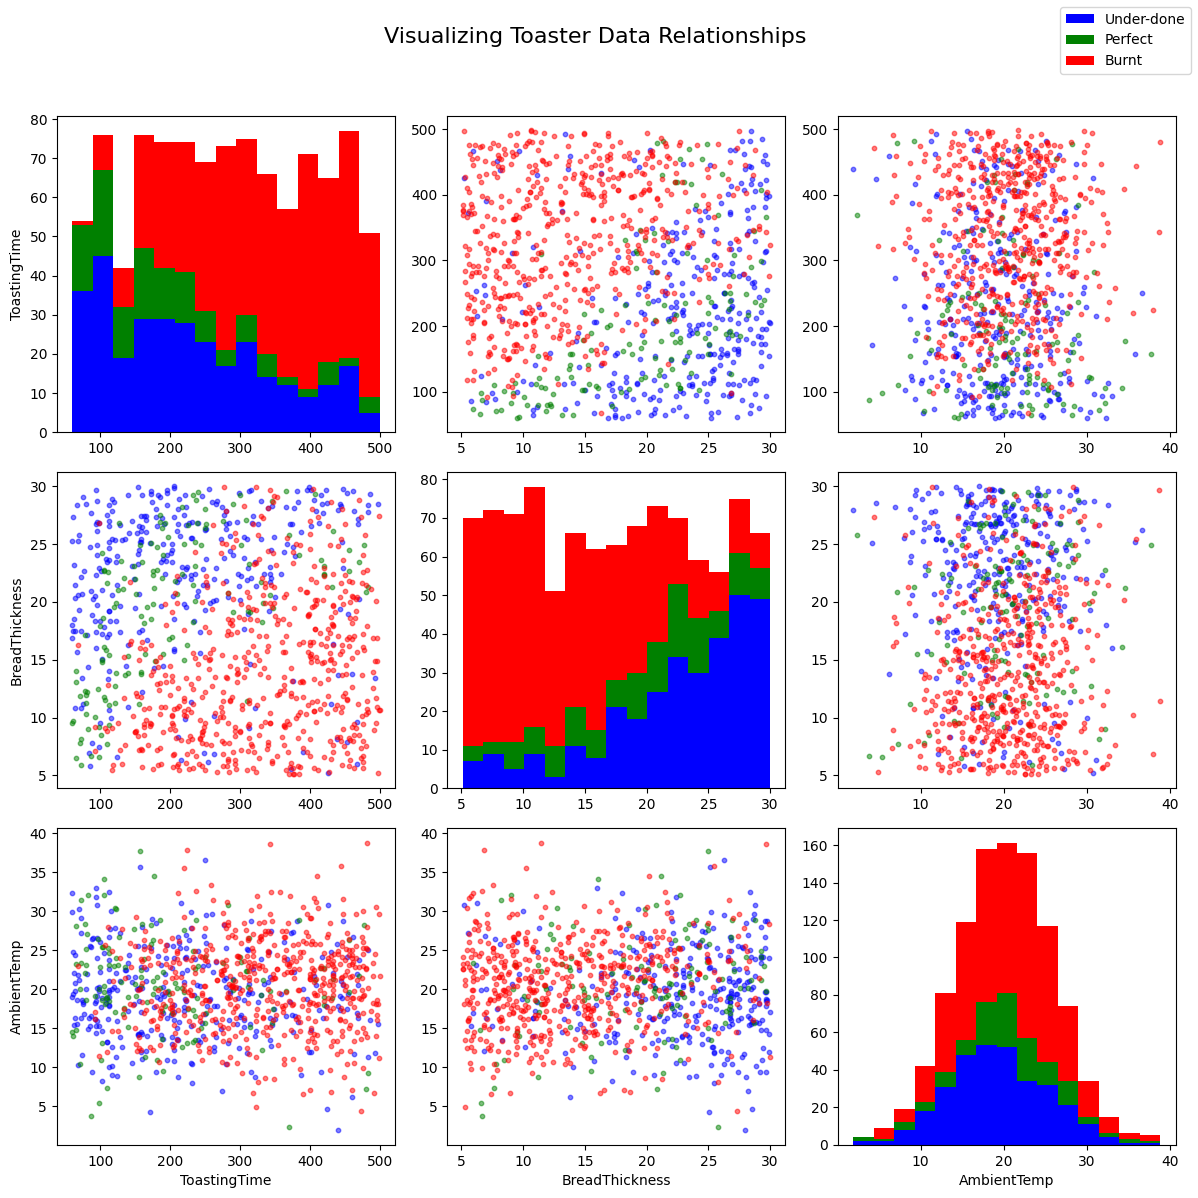

In [3]:
displayfeatures(df)

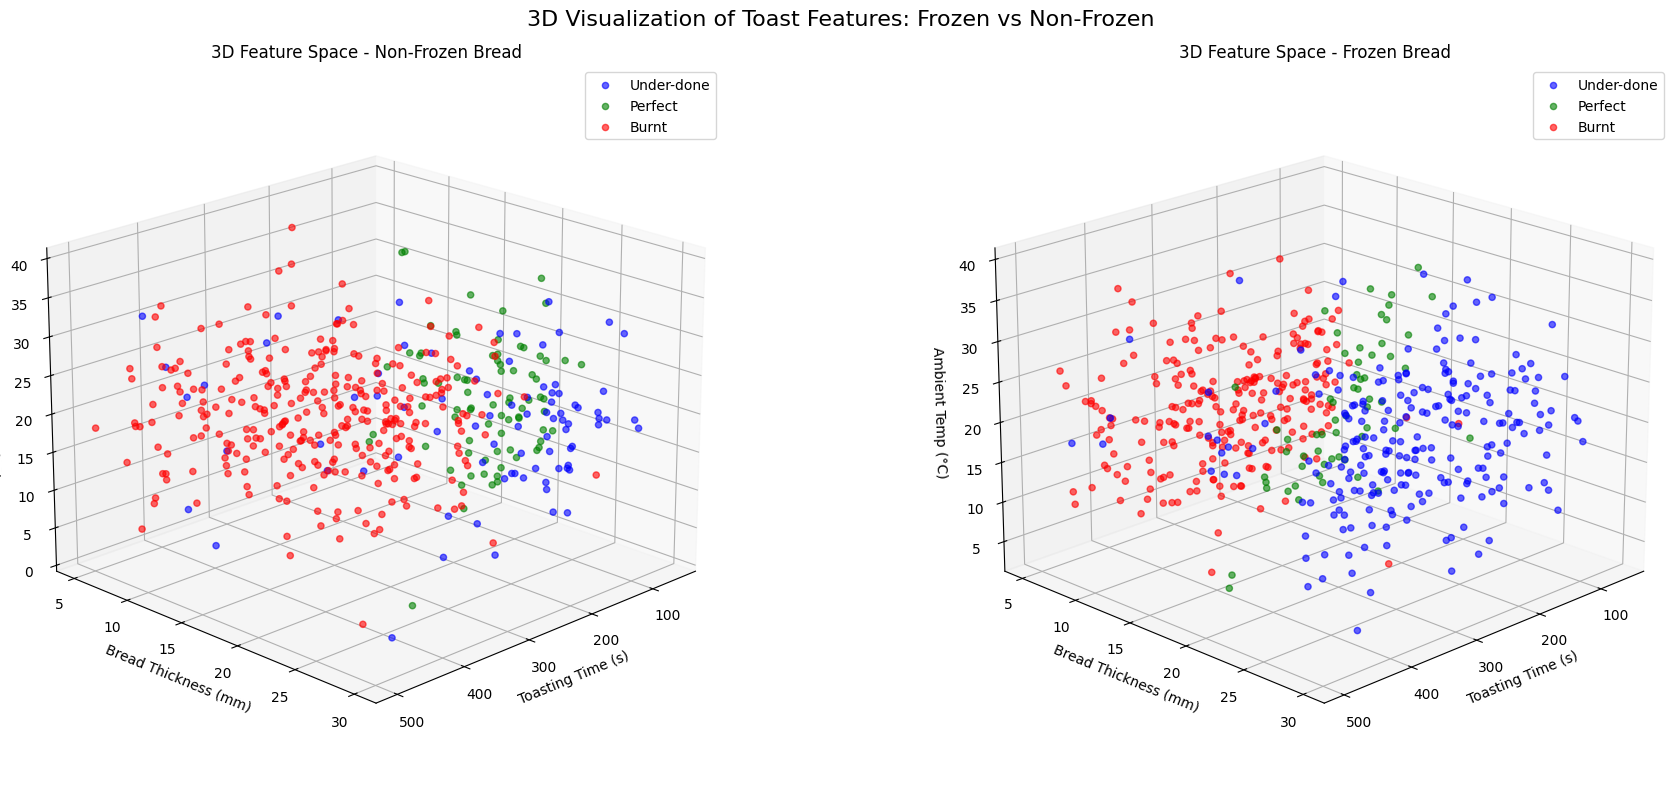

In [4]:
def displayfeatures3D_with_frozen(df):
    """
    3D visualization of the main features separated by frozen vs non-frozen bread
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    target_col = 'ToastState'
    class_labels = {0: 'Under-done', 1: 'Perfect', 2: 'Burnt'}
    colors = ['blue', 'green', 'red']
    
    # Create side-by-side 3D plots
    fig = plt.figure(figsize=(20, 8))
    
    frozen_states = [0, 1]  # 0 = not frozen, 1 = frozen
    frozen_labels = ['Non-Frozen Bread', 'Frozen Bread']
    
    for frozen_idx, is_frozen in enumerate(frozen_states):
        # Filter data for current frozen state
        frozen_df = df[df['IsFrozen'] == is_frozen]
        
        ax = fig.add_subplot(1, 2, frozen_idx + 1, projection='3d')
        
        # Plot each class with different colors
        for k in class_labels.keys():
            subset = frozen_df[frozen_df[target_col] == k]
            if len(subset) > 0:
                ax.scatter(subset['ToastingTime'], subset['BreadThickness'], subset['AmbientTemp'],
                          c=colors[k], label=class_labels[k], alpha=0.6, s=20)
        
        ax.set_xlabel('Toasting Time (s)')
        ax.set_ylabel('Bread Thickness (mm)')
        ax.set_zlabel('Ambient Temp (°C)')
        ax.set_title(f'3D Feature Space - {frozen_labels[frozen_idx]}')
        ax.legend()
        
        # Add some rotation for better viewing
        ax.view_init(elev=20, azim=45)
    
    plt.suptitle('3D Visualization of Toast Features: Frozen vs Non-Frozen', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the 3D function
displayfeatures3D_with_frozen(df)

## Step 1: Explore the data

Check what the data looks like using the two functions defined above, as well as the pandas and matplotlib functions seen during class:

- ```df.head()```
- ```df.describe()```
- boxplots, histograms, scatter plots, etc.

The plotting functions ```displayfeatures(df)``` and ```displayfeatures3D(df)``` do not consider whether the bread is frozen or not. You may want to copy these functions to display the data with respect to the bread frozen feature.



## Step 2: Making a Train-Test split

We need to split the data into two sets:
1. a training set that you will use for training the model
2. a testing set that will be used ONLY for testing. This testing set will never be integrated in the training, meaning that the model will have never seen that data before testing.

The reason for this split is that we want our model to **generalise** to new data rather than memorising the answers. Training with all the data without testing with new data will result in some of the worse **overfitting**.

Typically, we tend to use 70% of the data for training and 30% for testing, uniformly distributed across the data. You can extract manually, or use ```sklearn.model_selection.train_test_split```. This function automatically generates four dataframes:
- ```X_train``` The *training* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```X_test``` The *testing* dataframe, containing the 'ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen' features.
- ```y_train``` The *training* labels dataframe, containing the 'ToastState' result.
- ```y_test``` The *testing* labels dataframe, containing the 'ToastState' result. This is the **ground truth** that you will compare your testing data against.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[['ToastingTime', 'BreadThickness', 'AmbientTemp', 'IsFrozen']],
    df['ToastState'],
    test_size=0.3,
    random_state=42
)

print("-----------------")
print("X_train")
print("-----------------")
print(X_train.describe())
print("-----------------")
print("X_test")
print("-----------------")
print(X_test.describe())
print("-----------------")
print("y_train")
print("-----------------")
print(y_train.describe())
print("-----------------")
print("y_test")
print("-----------------")
print(y_test.describe())

-----------------
X_train
-----------------
       ToastingTime  BreadThickness  AmbientTemp    IsFrozen
count    700.000000      700.000000   700.000000  700.000000
mean     280.741429       17.520332    20.007336    0.528571
std      122.948645        7.277370     5.866433    0.499540
min       60.000000        5.123500     1.882927    0.000000
25%      181.000000       10.936605    15.987421    0.000000
50%      282.000000       17.465699    20.099368    1.000000
75%      389.250000       23.766238    24.015058    1.000000
max      499.000000       29.985343    38.826491    1.000000
-----------------
X_test
-----------------
       ToastingTime  BreadThickness  AmbientTemp   IsFrozen
count    300.000000      300.000000   300.000000  300.00000
mean     278.963333       17.090651    20.437731    0.54000
std      123.749593        7.198787     5.800423    0.49923
min       60.000000        5.115801     4.374717    0.00000
25%      177.000000       10.712463    16.943549    0.00000
50% 

## Step 3: Simple Classifiers



### Logistic Regression

Let's start with logistic regression. We will use ```sklearn.linear_model.LogisticRegression```. Typical use is as follows:

```python
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Predict values for our testing data
predictions = log_reg.predict(X_test)
```

The ```LogisticRegression``` function can be initialized with some interesting arguments:
- ```max_iter``` the maximum number of iterations. Default is 100, but as our data is quite complex, you may have to increase to reach convergence
- ```solver``` the solver used to fit the data. Some solvers may be more efficient for some data than others.

Once we have trained the Logistic Regression and done predictions, we can check the accuracy as follows:

```python
from sklearn.metrics import accuracy_score

# Calculate the accuracy between our prediction and the ground truth of our testing data
accuracy = accuracy_score(y_test, predictions)
```


Documentation is here: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression and here: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### Tasks

1. Train a logistic regressor on your training and testing data.
2. Answer the following questions
    1. What is the accuracy?
    2. Change the max number of iterations. How does the accuracy change?
    3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?

In [8]:
# --- TODO: Train a logistic regressor on your training and testing data. --- #
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10,solver='newton-cholesky')
#model = LogisticRegression(max_iter=520)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Converge in n iter:", model.n_iter_)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("Classification Report:")
print(classification_report(y_test, predictions))

Converge in n iter: [5]
Accuracy: 0.79
Confusion Matrix:
[[ 73   7  21]
 [ 15   9  12]
 [  8   0 155]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       101
           1       0.56      0.25      0.35        36
           2       0.82      0.95      0.88       163

    accuracy                           0.79       300
   macro avg       0.72      0.64      0.66       300
weighted avg       0.77      0.79      0.77       300



**TODO:** 

Double click the cell and answer the following questions

1. What is the accuracy?  
How many percentage of prediction against the test dataset that's computed using the fitted model being correct.

----
2. Change the max number of iterations. How does the accuracy change?  
It remains the same until it dropped below `model.n_iter_`, where it starts to decrease.

----
3. Change the solver. How does the accuracy change? How fast does it converge (use ```log_reg.n_iter_``` to find the number of iterations before convergence)?  
Change the solver to `newton-cholesky`, it provides me the same accuracy in 5 iters as default `lbfgs` in 516 iters. The rate is much faster at a cost of higher memory usage.


### Step 4: Decision Tree Classifier

Let us move to decision tree models. Typical use of `sklearn.tree.DecisionTreeClassifier` is very similar to other classifiers:

```python
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
# We can set a random_state for reproducibility of results
dt_clf = DecisionTreeClassifier(random_state=42)

# Train the model
dt_clf.fit(X_train, y_train)

# Predict values
predictions = dt_clf.predict(X_test)
```

The main advantage of a decision tree is its interpretability. However, a major disadvantage is its tendency to **overfit**. A tree that is too deep will learn the noise in the training data and won't generalize well to new data. A key parameter to control this is `max_depth`.

Documentation is here: https://scikit-learn.org/stable/modules/tree.html and here: https://scikit-learn.org/stable/api/sklearn.tree.html

#### Tasks

1.  Train a default `DecisionTreeClassifier` on your training data and evaluate its accuracy on the testing data. How does it compare to the Logistic Regression model?
2.  Trees can be visualized! Use the code below to plot the rules your tree has learned.
    1.   First, train a new tree but limit its depth by setting `max_depth=3` to make the plot readable.
    2.   You can plot the tree using ```plot_tree``` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Plot the tree.
    3. Can you interpret the first couple of decisions the model makes?
3.  Investigate overfitting. Train multiple decision trees with `max_depth` varying from 1 to 20. For each depth, calculate and record both the **training accuracy** (predicting on `X_train`) and the **testing accuracy** (predicting on `X_test`). Plot both accuracies on the same graph against `max_depth`.
    1.   At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)?

In [6]:
%config InlineBackend.figure_format = 'retina'

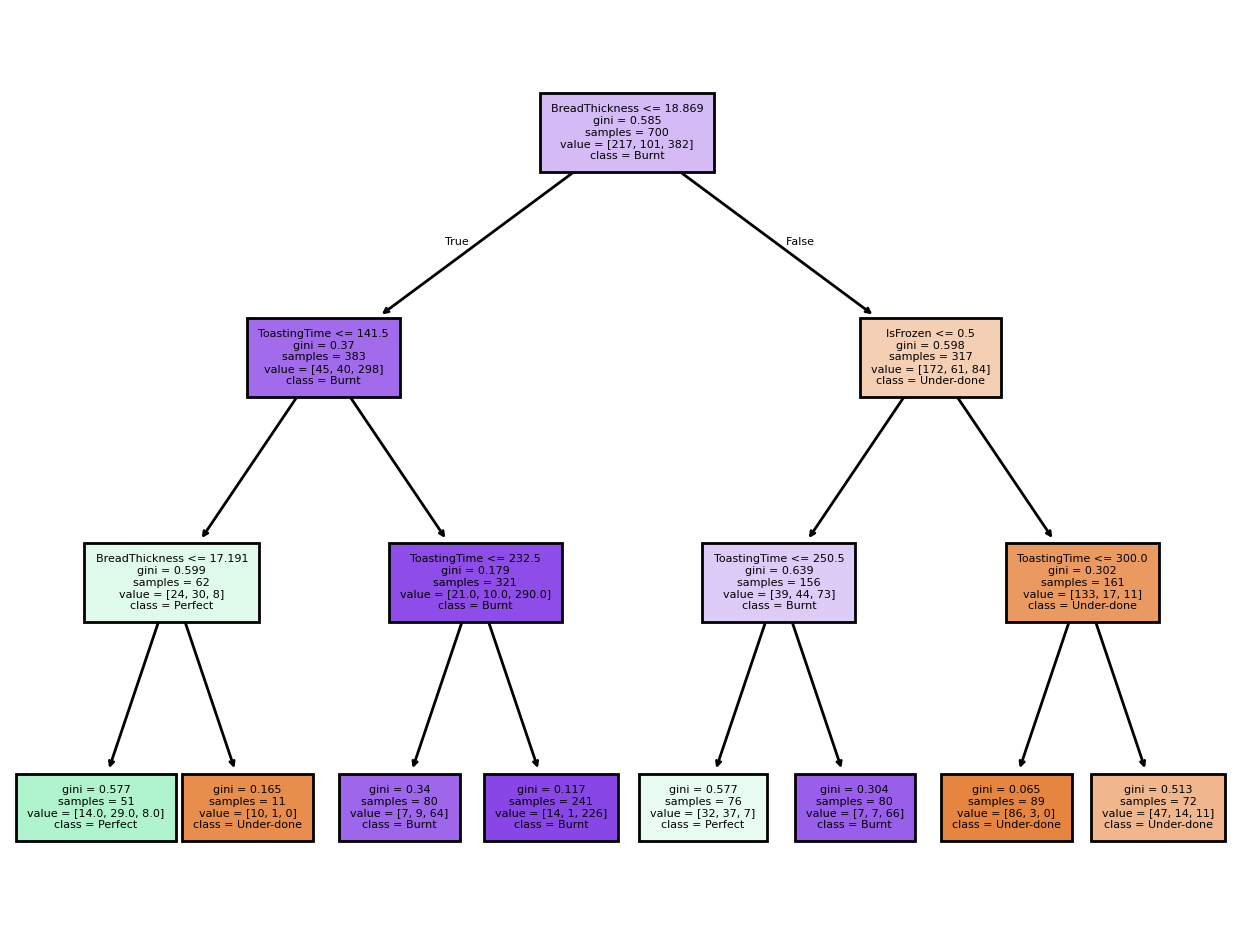

In [8]:
# --- TODO: Train a default `DecisionTreeClassifier`, and visualize the tree. --- #
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
for i in range(1, 21):
    dt_clf = DecisionTreeClassifier(random_state=42, max_depth=i)
    dt_clf.fit(X_train, y_train)
    if i==3:
        plot_tree(dt_clf, 
                 feature_names=X_train.columns,  # Add feature names
                 class_names=['Under-done', 'Perfect', 'Burnt'],  # Add class names
                 filled=True,  # Fill nodes with colors
                 fontsize=4)  # Adjust font size
        plt.tight_layout()
        plt.show()
        break

    t_predictions = dt_clf.predict(X_train)
    t_accuracy = accuracy_score(y_train, t_predictions)
    # print(f"Training Accuracy - D{i}:", t_accuracy)

    predictions = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    # print(f"Accuracy - D{i}:", accuracy)


**TODO:** 

Double click the cell and answer the following questions

4. write a few words to interpret the first couple of decisions the model makes.  
L1 decides to go to left or right node based on BreadThickness. L2 decides based on ToastingTime if going left, and isFrozen if going right. L3 decides based on BreadThickness or ToastingTime depending on the previous decisions.
----

Training Accuracy - D1: 0.6714285714285714
Accuracy - D1: 0.6466666666666666
Training Accuracy - D2: 0.7514285714285714
Accuracy - D2: 0.6966666666666667
Training Accuracy - D3: 0.8071428571428572
Accuracy - D3: 0.73
Training Accuracy - D4: 0.84
Accuracy - D4: 0.73
Training Accuracy - D5: 0.8628571428571429
Accuracy - D5: 0.75
Training Accuracy - D6: 0.9085714285714286
Accuracy - D6: 0.7566666666666667
Training Accuracy - D7: 0.9428571428571428
Accuracy - D7: 0.7433333333333333
Training Accuracy - D8: 0.9585714285714285
Accuracy - D8: 0.7333333333333333
Training Accuracy - D9: 0.9742857142857143
Accuracy - D9: 0.7433333333333333
Training Accuracy - D10: 0.9914285714285714
Accuracy - D10: 0.7233333333333334
Training Accuracy - D11: 0.9957142857142857
Accuracy - D11: 0.7133333333333334
Training Accuracy - D12: 1.0
Accuracy - D12: 0.7266666666666667
Training Accuracy - D13: 1.0
Accuracy - D13: 0.7266666666666667
Training Accuracy - D14: 1.0
Accuracy - D14: 0.7266666666666667
Training Accu

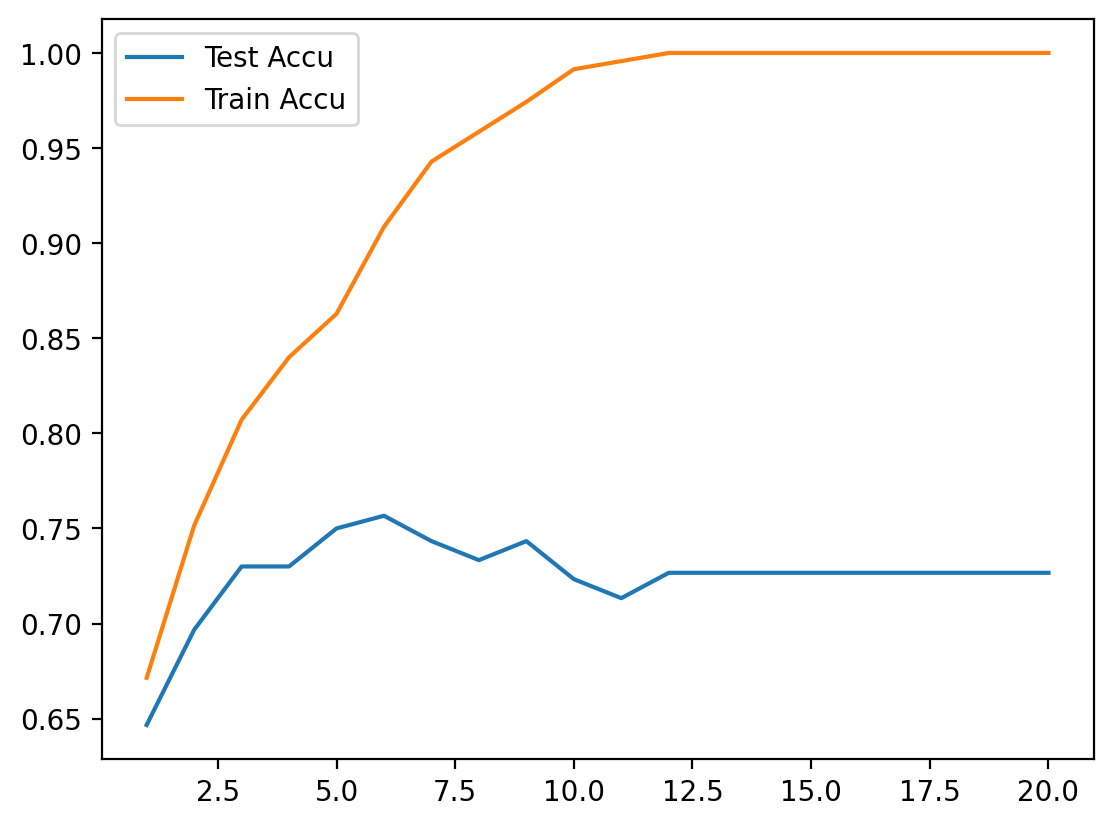

In [9]:
# --- TODO: Investigate overfitting: maybe train multiple decision trees, and explore the overfitting issue. --- #
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

depth = []
accu = []
train_accu = []
for i in range(1, 21):
    dt_clf = DecisionTreeClassifier(random_state=42, max_depth=i)
    dt_clf.fit(X_train, y_train)

    t_predictions = dt_clf.predict(X_train)
    t_accuracy = accuracy_score(y_train, t_predictions)
    print(f"Training Accuracy - D{i}:", t_accuracy)

    predictions = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy - D{i}:", accuracy)

    depth.append(i)
    accu.append(accuracy)
    train_accu.append(t_accuracy)

fig, ax = plt.subplots()
ax.plot(depth, accu, label="Test Accu")
ax.plot(depth, train_accu, label="Train Accu")
plt.legend()
plt.show()

**TODO:** 

Double click the cell and answer the following questions

5. At what depth does the model start to significantly overfit (i.e., training accuracy keeps increasing while testing accuracy stagnates or drops)?  
At a depth of 7, the training accuracy continues to increase while the testing accuracy starts to drop, indicating significant overfitting.

----

### Step 5: Support Vector Machines (SVM)

Let us use SVM to try to find splits in data that are not necessarily linear. We will use `sklearn.svm.SVC` (Support Vector Classifier). Typical use is as follows:

```python
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example usage

# Initialize an SVM model with the 'rbf' kernel, and a 'C' hyperparameter at 1
svm_clf = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict the values
svm_predictions = svm_clf.predict(X_test)

# Get the accuracy with respect to the ground truth
accuracy = accuracy_score(y_test, svm_predictions)
```

Documentation is here: https://scikit-learn.org/stable/modules/svm.html and here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html


#### Tasks

1.  Train a default `SVC` model and evaluate its accuracy on the test set.
2.  The `kernel` is a key parameter. Train and evaluate `SVC` models with the following kernels: `'linear'`, `'poly'`, `'rbf'`, and `'sigmoid'`.
    1. Which one performs best for our toast data? From grid search optimization, the 'rbf' kernel performs the best for our toast data.
    2. Why do you think it is? RBF kernel can handle non-linear relationships well by mapping data into higher-dimensional space, which is beneficial for our toast data that likely has complex interactions between features.
3.  The `C` parameter is a regularisation parameter. It controls the trade-off between a large margin and a low error rate on the training data. A smaller `C` creates a wider margin but may misclassify more points, while a larger `C` risks creating a more complex, overfitted boundary.
    1.   Using the best kernel you found in the previous step, experiment with different values for `C` (e.g., 0.1, 1, 10, 100). How does the accuracy change?  As C increases, the accuracy tends to improve up to a point, as the model becomes more flexible and can better fit the training data. However, beyond a certain value, increasing C further may lead to overfitting, causing the accuracy on the test set to decrease.
4. Another parameter is `gamma`. It dictates the influence of a single training example on the model.  A low gamma value means that each training point affects a wider area, leading to a smoother, more generalized decision boundary. A high gamma value restricts the influence to a smaller, closer range, creating a more complex decision boundary that closely follows the training data, which can lead to overfitting. By default, `gamma` is set to `scale`, which means it scales with the data.
    1. Using the best kernel and `C` you found in the previous step, experiment with different values for `gamma` (e.g., 0.1, 1, 10, 100). How does the accuracy change?  As gamma increases, the model becomes more sensitive to individual data points, which can improve accuracy on the training set but may lead to overfitting and decreased accuracy on the test set.


In [10]:
# --- TODO: Train a default SVC and evaluate on test dataset --- #
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize an SVM model with the 'rbf' kernel, and a 'C' hyperparameter at 1
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict the values
svm_predictions = svm_clf.predict(X_test)

# Get the accuracy with respect to the ground truth
accuracy = accuracy_score(y_test, svm_predictions)
print("Linear accuracy:", accuracy)

Linear accuracy: 0.7533333333333333


In [11]:
# --- TODO: Train multiple SVCs with different kernels, and evaluate the results. --- #
kernel_list = ['rbf', 'linear', 'poly']
for k in kernel_list:
  svm_clf = SVC(kernel=k, C=1.0, random_state=42)

  # Train the model
  svm_clf.fit(X_train, y_train)

  # Predict the values
  svm_predictions = svm_clf.predict(X_test)

  # Get the accuracy with respect to the ground truth
  accuracy = accuracy_score(y_test, svm_predictions)
  print(k, "accuracy:", accuracy)

rbf accuracy: 0.66
linear accuracy: 0.7533333333333333
poly accuracy: 0.6833333333333333


In [18]:
# --- TODO: with the best kernel in last step, do more experiments with C parameter --- #
c_list = [0.1, 1, 10, 100]
for c in c_list:
  svm_clf = SVC(kernel='linear', C=c, random_state=42)

  # Train the model
  svm_clf.fit(X_train, y_train)

  # Predict the values
  svm_predictions = svm_clf.predict(X_test)

  # Get the accuracy with respect to the ground truth
  accuracy = accuracy_score(y_test, svm_predictions)
  print(c, "accuracy:", accuracy)

0.1 accuracy: 0.8
1 accuracy: 0.7533333333333333
10 accuracy: 0.76
100 accuracy: 0.78


In [13]:
# --- TODO: with the best set-up from previous steps, explore parameter gamma. --- #
gamma_list = [0.1, 1, 10, 100]
for ga in gamma_list:
  svm_clf = SVC(kernel='linear', C=0.1, gamma=ga, random_state=42)

  # Train the model
  svm_clf.fit(X_train, y_train)

  # Predict the values
  svm_predictions = svm_clf.predict(X_test)

  # Get the accuracy with respect to the ground truth
  accuracy = accuracy_score(y_test, svm_predictions)
  print(ga, "accuracy:", accuracy)

0.1 accuracy: 0.8
1 accuracy: 0.8
10 accuracy: 0.8
100 accuracy: 0.8


In practice, we tend to automate the tuning of SVM's hyperparameter. This process involves testing different hyperparameter values to find the combination that minimises loss and maximizes accuracy on a given dataset.

Here, we are going to use the GridSearch algorithm to find the best combination of kernel, C, and gamma.

Task:
1. Run the following script. What is the result? Does it differ from your manual tuning?

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


# 2. Create a pipeline to scale data and run SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# 3. Define a parameter grid to search
# Use a logarithmic scale for C and gamma
param_grid = {
    'svm__kernel': ['linear','poly','rbf','sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

# 4. Perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the best model
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test set score with best model: {grid_search.score(X_test, y_test):.3f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters found: {'svm__C': 100, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best cross-validation score: 0.847
Test set score with best model: 0.820


**TODO:** 

Double click the cell and answer the following questions

6. Does it differ from your manual tuning?  
It picked `rbf` as the best kernel instead of the manually picked `linear`. It also picked a `c` of 100 instead of 0.1. Both picked 0.1 for gamma.  
The grid search results in a better test set score with best model of 0.820 instead of 0.8. It reveals that grid search can possibly find better hyperparameters than fixed sequenced manual tuning.

----

### Step 6: Random Forest

Now that we have gone through the single expert models, we can move to ensemble learning with Random Forest.

```python
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
```

Documentation is here: https://scikit-learn.org/stable/modules/ensemble.html#random-forests and here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Tasks

1.  Train a `RandomForestClassifier` from `sklearn.ensemble` on the data. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?
2.  We can calculate the **feature importance** to show how much each feature contributed to reducing impurity across all the trees.
    *   After training your model, access the feature importances using `your_model.feature_importances_`.
    *   Plot the importance . Which features are most important for determining the state of the toast? Does this align with your intuition?

Hint: to plot the importances, you can use:

```python
importances = rf_clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
```

In [15]:
# --- TODO: Train a randowm forest classifier  --- #
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Feature Importances:", rf_clf.feature_importances_)

Random Forest Accuracy: 0.8033333333333333
Feature Importances: [0.33037475 0.40882441 0.15075052 0.11005032]


**TODO:** 

Double click the cell and answer the following questions

7. How does its accuracy compare to the single `DecisionTreeClassifier` and the other models?  
It got a better accuracy compared to the single `DecisionTreeClassifier` even at its peak, tho it is defeated by SVM with tuned hyperparameters.

----

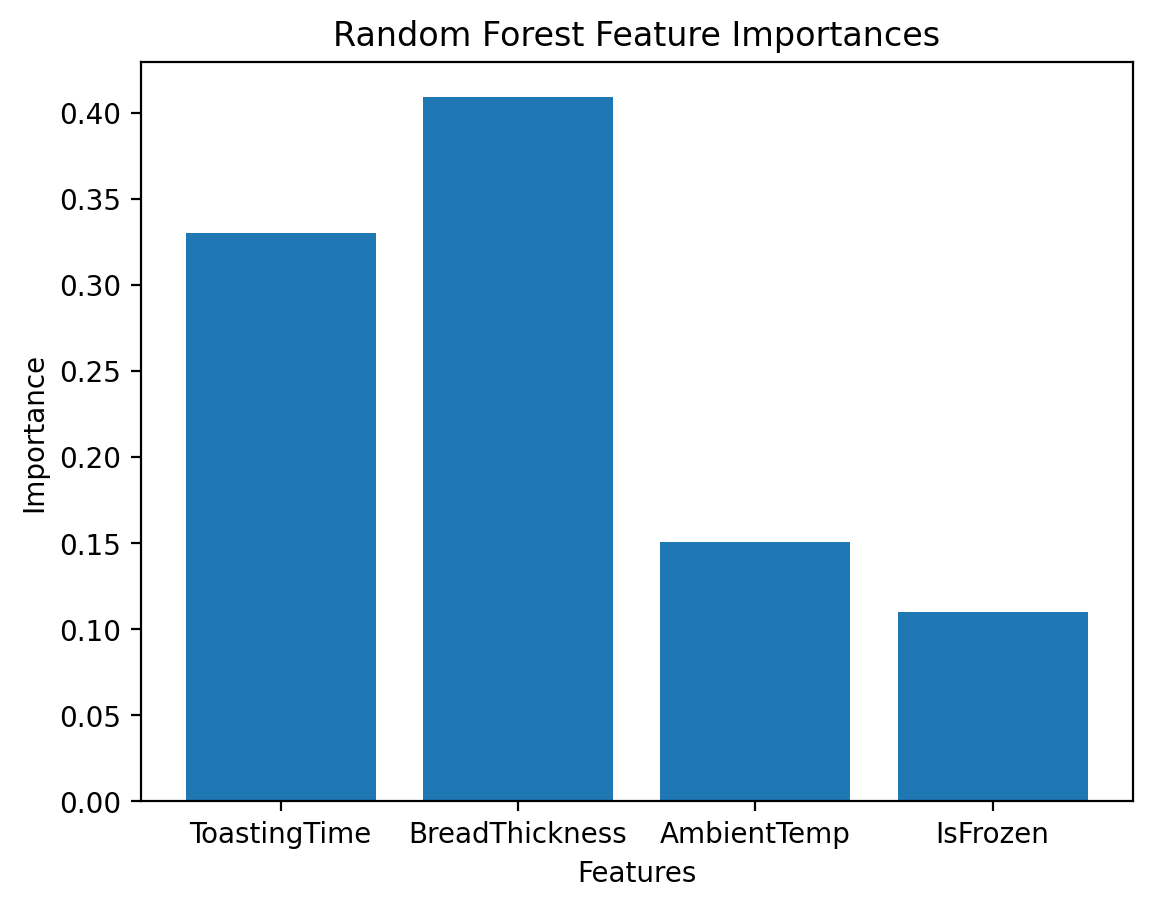

In [16]:
# --- TODO: find and visualize feature_importance of your model  --- #
plt.bar(X_train.columns, rf_clf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

**TODO:** 

Double click the cell and answer the following questions

8. Which features are most important for determining the state of the toast? Does this align with your intuition?  
BreadThickness is the most important feature for the determination of toast state, which aligns with my intuition as thicker bread generally requires longer toasting times to achieve the desired level of doneness.

----

### Step 7: XGBoost

Finally, let's move to XGBoost. This time, we need to  import it from the xgboost library. Usage is the same as the other libraries.

Documentation is here: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

#### Task:

1.  Train a default `xgboost.XGBClassifier` and evaluate its accuracy. Note that if you get a warning about `use_label_encoder=False`, you can safely ignore it or add the parameter `use_label_encoder=False` to the classifier to suppress it.
2.  **Tuning:** XGBoost has many parameters, but two of the most important are `n_estimators` (the number of trees to build) and `learning_rate` (which shrinks the contribution of each tree). A lower learning rate requires more estimators, but can often lead to a more robust model.
    1.   Try training a model with more estimators, for example `n_estimators=500`.
    2.   Now, try that again but with a lower learning rate, for example `n_estimators=500, learning_rate=0.1`.
    3. You can try some other interesting parameters, such as `max_depth` (the max tree depth), or `subsample` (the amount of data passed to a tree).
    4.   How do these changes affect accuracy and the risk of overfitting? As you increase `n_estimators`, the model may fit the training data better, potentially improving accuracy but also increasing the risk of overfitting. Lowering the `learning_rate` can help mitigate overfitting by making the model learn more slowly, which often leads to better generalization on unseen data.
3.  Like Random Forest, XGBoost can also calculate **feature importance**. This is crucial for understanding what drives the model's predictions.
    1.   After training your best XGBoost model, access the feature importances and plot them using the same method as in the Random Forest section.
    2.   Compare the feature importances from XGBoost with those from Random Forest. Do the models agree on which features are most important?
4. Same as SVM, you can run a GridSearch algorithm to find the optimal parameters. Adapt the script provided in the SVM section to find the optimal learning rate, number of estimators, and any other parameter you can think of.


**Create cells of `python` to fill in your code, and of `markdown` to answer the questions.**


## Answers:
1. How do these changes affect accuracy and the risk of overfitting?
It hits the best accuracy with n estimators around 1000 and learning rate around 0.01. The higher the learning rate, the more risk of overfitting since it's likely to fit the noise in the training data.
2. Compare the feature importances from XGBoost with those from Random Forest. Do the models agree on which features are most important?
It also picked BreadThickness as the most important feature. Both models agree on the feature importance ranking.

In [76]:
# --- TODO: Train a random forest classifier  --- #
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

xgb_clf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05)
xgb_clf.fit(X_train, y_train)
xgb_predictions = xgb_clf.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", xgb_accuracy)
print("Feature Importances:", xgb_clf.feature_importances_)

XGBoost Accuracy: 0.79
Feature Importances: [0.19564506 0.20501731 0.09384607 0.50549155]


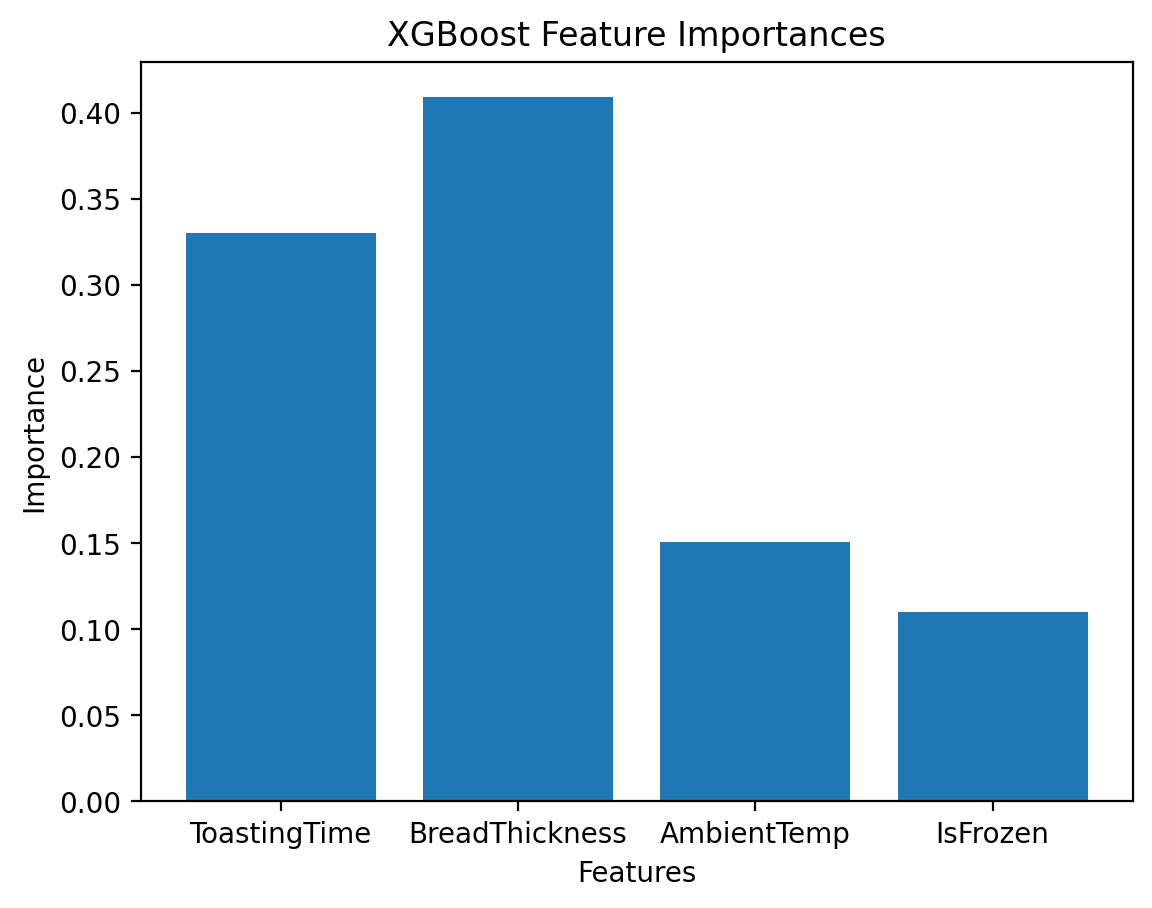

In [77]:
# --- TODO: find and visualize feature_importance of your model  --- #
plt.bar(X_train.columns, rf_clf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importances')
plt.show()

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# 2. Create a pipeline to scale data and run XGBoost

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier())
])

# 3. Define a parameter grid to search
# Use a logarithmic scale for C and gamma
param_grid = {
    'xgb__n_estimators': [1, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.0]
}
    
# 4. Perform the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. Evaluate the best model
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Test set score with best model: {grid_search.score(X_test, y_test):.3f}")

Fitting 5 folds for each of 104 candidates, totalling 520 fits
Best parameters found: {'xgb__learning_rate': 0.01, 'xgb__n_estimators': 700}
Best cross-validation score: 0.824
Test set score with best model: 0.803


### Step 9: Model Comparison and Conclusion

You have now trained and evaluated several different classification models, from simple linear models to powerful ensembles. Let's summarize the results to determine which is best for predicting the perfect toast.

#### Task

1.  Fill in the table below with the best accuracy you achieved for each model type.
2.  Answer the following questions:
    *   Which model gave the highest accuracy? SVM
    *   Which model do you think is the most *interpretable* (easiest to explain to someone)? I think decision tree is the most interpretable. Why?
        *   It provides a clear tree where it tells you what parameter it is used for determinating which node it should go to next. You can visualise the tree and explain the decisions step by step.
    *   Considering both performance and interpretability, which model would you choose to deploy in your "smart toaster"? Justify your choice.
        *   I think I would use SVM. Although decision tree is more interpretable, SVM provides a significantly higher accuracy which is crucial for the toaster to consistently produce perfect toast. The improved performance outweighs the interpretability in this application.

| Model Type | Best Test Accuracy |
| :--- | :--- |
| Logistic Regression | 0.79 |
| Decision Tree | 0.7567 |
| Support Vector Machine (SVC) | 0.82 |
| Random Forest | 0.80 |
| XGBoost | 0.80 |

### Step 10: Fine-tune your best models

1.  Please use whatever tools, libraries or methods you know to fine-tune your models. 
2.  Pick one with the best performance.
3.  Write down the trainining and evaluation process about this best model below, with anything that you think is necessary.
4.  We will use another blackbox dataset to test your model. The work will be graded based on computing efficiency (runtime) and accuracy.